<a href="https://colab.research.google.com/github/haohoang/DataScienceDevC/blob/master/Weekly_Project_BBC_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [14]:
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline

from tensorflow import keras
layers = keras.layers
models = keras.models
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.sample(5)

,category,text
1511,sport,dogged federer claims dubai crown world number...
1510,business,soros group warns of kazakh close the open soc...
1899,entertainment,potter director signs warner deal harry potter...
934,politics,civil servants in strike ballot the uk s bigge...
1638,sport,a november to remember last saturday one news...


In [5]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
# Your code here
bbc['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [9]:
train_size = int(len(bbc) * .8)
print("Train size: %d" % train_size)
print("Test size: %d" % (len(bbc) - train_size))

Train size: 1780
Test size: 445


In [10]:
def train_test_split(bbc, train_size):
  train = bbc[:train_size]
  test = bbc[train_size:]
  return train, test

In [12]:
train_cat, test_cat = train_test_split(bbc['category'], train_size)
train_text, test_text = train_test_split(bbc['text'], train_size)

In [15]:
max_words = 1000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)

In [17]:
tokenize.fit_on_texts(train_text)
x_train = tokenize.texts_to_matrix(train_text)
x_test = tokenize.texts_to_matrix(test_text)

In [18]:
encoder = LabelEncoder()
encoder.fit(train_cat)
y_train = encoder.transform(train_cat)
y_test = encoder.transform(test_cat)

In [19]:
num_classes = np.max(y_train) + 1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("y_train shape: ", y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1780, 1000)
x_test shape: (445, 1000)
y_train shape:  (1780, 5)
y_test shape: (445, 5)


In [21]:
batch_size = 32
epochs = 2
drop_ratio = 0.5

In [25]:
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/2
51/51 [==============================] - 0s 8ms/step - loss: 0.4397 - accuracy: 0.8708 - val_loss: 0.1459 - val_accuracy: 0.9382
Epoch 2/2
51/51 [==============================] - 0s 4ms/step - loss: 0.0434 - accuracy: 0.9938 - val_loss: 0.1204 - val_accuracy: 0.9551


In [27]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

14/14 [==============================] - 0s 2ms/step - loss: 0.1428 - accuracy: 0.9618
Test loss: 0.1428109109401703
Test accuracy: 0.9617977738380432


In [28]:
def run_experiment(bach_size, epochs, drop_ratio):
  print("batch size: {}, epochs: {}, drop_ratio: {}".format(batch_size, epochs, drop_ratio))
  model = models.Sequential()
  model.add(layers.Dense(512, input_shape=(max_words,)))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(drop_ratio))
  model.add(layers.Dense(num_classes))
  model.add(layers.Activation('softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      validation_split=0.1)
  score = model.evaluate(x_test, y_test,
                         batch_size=batch_size, verbose=0)
  print("\tTest loss: ", score[0])
  print("\tTest accuracy: ", score[1])

In [29]:
batch_size = 16
epochs = 4
drop_ratio = 0.4
run_experiment(batch_size, epochs, drop_ratio)

batch size: 16, epochs: 4, drop_ratio: 0.4
	Test loss:  0.11845178157091141
	Test accuracy:  0.9617977738380432


In [ ]:
text_labels = encoder.classes_

for i in range(10):
  prediction = model.predict(np.array([x_test[i]]))
  predicted_label = text_labels[np.argmax(prediction)]
  print("Actual label:" + test_cat.iloc[i])
  print("Predicted label: " + predicted_label + "\n")

In [31]:
y_softmax = model.predict(x_test)
y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
  probs = y_test[i]
  index_arr = np.nonzero(probs)
  one_hot_index = index_arr[0].item(0)
  y_test_1d.append(one_hot_index)
for i in range(0, len(y_softmax)):
  probs = y_softmax[i]
  predicted_index = np.argmax(probs)
  y_pred_1d.append(predicted_index)

In [34]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,  j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.ylabel("True label", fontsize=25)
  plt.xlabel("Predicted label", fontsize=25 )

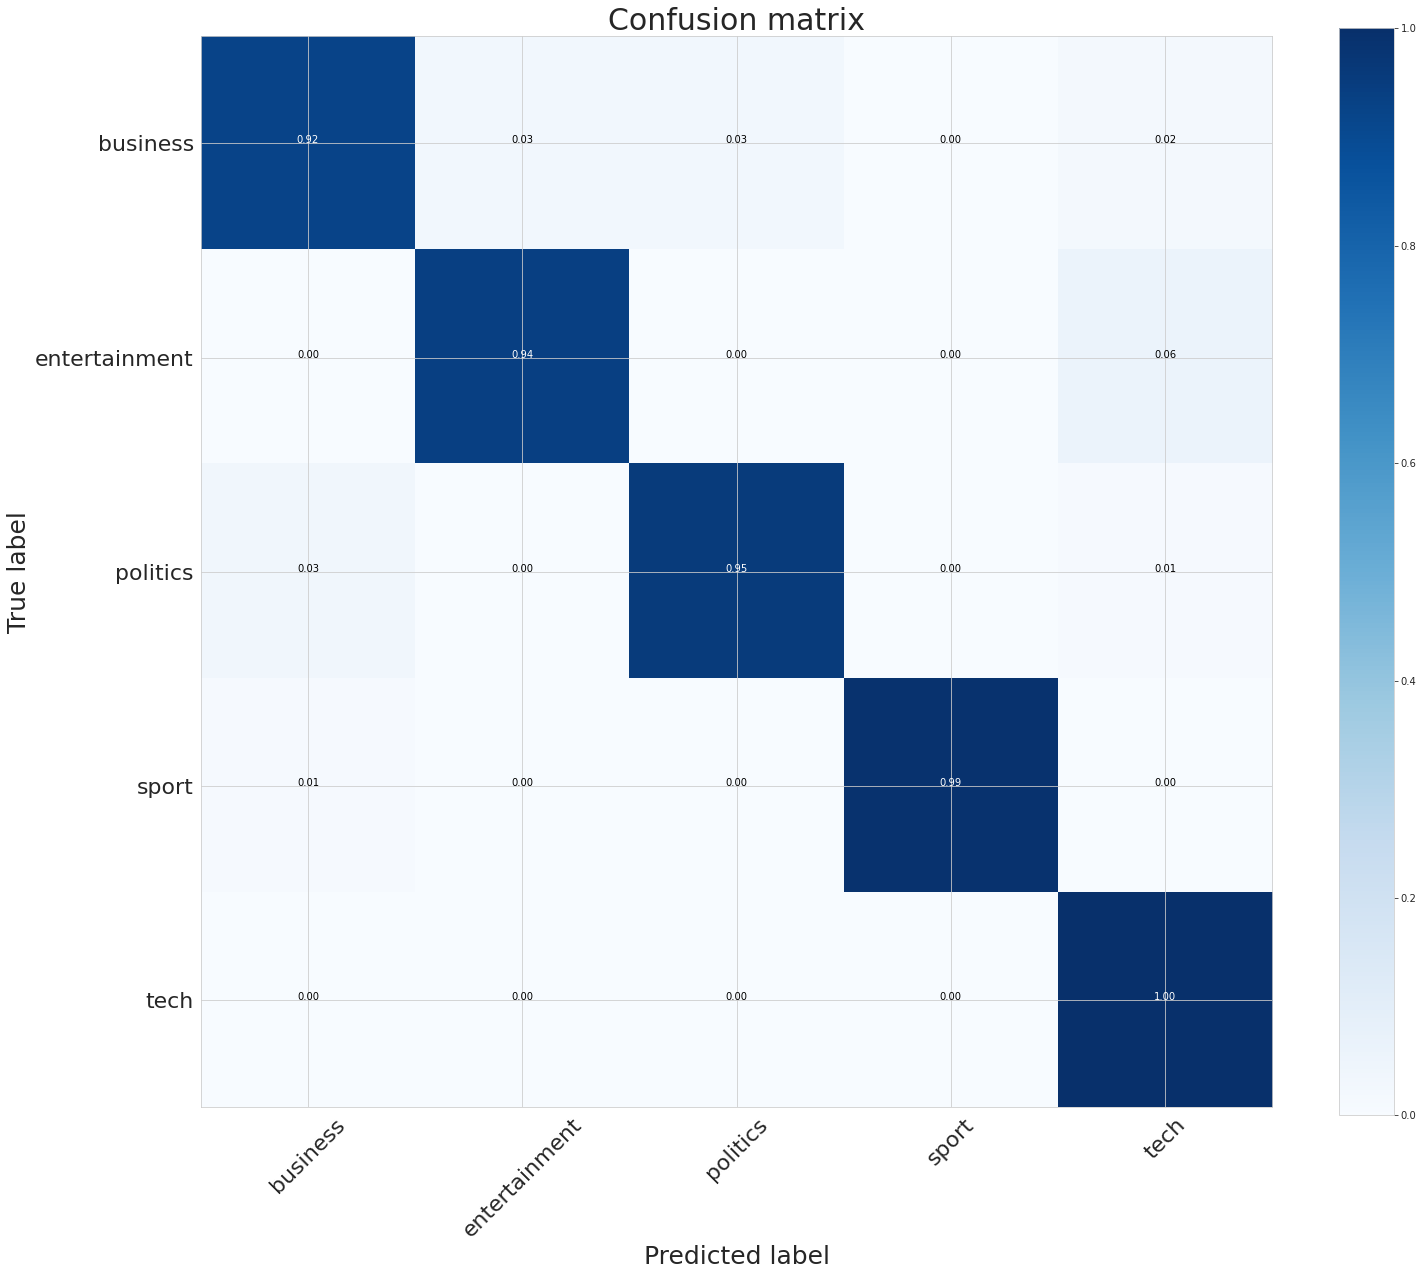

In [35]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24, 20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()